In [92]:
from pyntcloud import PyntCloud 
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
import pandas as pd
import os
import sys
import pdb

def Detect_edges():
    # Load the XYZ file as a DataFrame
    df = pd.read_csv("/Users/aagaa/Documents/GitHub/R-D/Drawings/STL/test.xyz", sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])
    #df = pd.read_csv("/Users/aagaa/Documents/GitHub/R-D/Code/Leihui Code/dataset/scanning_repository/horse.xyz", sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])

    # Convert DataFrame to a PyntCloud object
    pcd1 = PyntCloud(df)

    #pcd1 = PyntCloud.from_file("/Users/aagaa/Documents/GitHub/R-D/Code/Leihui Code/dataset/synethsis/cube-isometric.xyz")
    #pcd1 = PyntCloud.from_file("/TetrahedronMultiple.pcd")
    #pcd1 = PyntCloud.from_file("/ArtificialPointClouds/CubeFractal2.pcd")
    output_dir = "./detected_edge/"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # define hyperparameters
    k_n = 6
    thresh = 0.03

    pcd_np = np.zeros((len(pcd1.points),6))

    # find neighbors
    kdtree_id = pcd1.add_structure("kdtree")
    k_neighbors = pcd1.get_neighbors(k=k_n, kdtree=kdtree_id) 

    # calculate eigenvalues
    ev = pcd1.add_scalar_field("eigen_values", k_neighbors=k_neighbors)

    x = pcd1.points['x'].values 
    y = pcd1.points['y'].values 
    z = pcd1.points['z'].values 

    e1 = pcd1.points['e3('+str(k_n+1)+')'].values
    e2 = pcd1.points['e2('+str(k_n+1)+')'].values
    e3 = pcd1.points['e1('+str(k_n+1)+')'].values

    sum_eg = np.add(np.add(e1,e2),e3)
    sigma = np.divide(e1,sum_eg)
    sigma_value = sigma
    #pdb.set_trace()
    #img = ax.scatter(x, y, z, c=sigma, cmap='jet')

    # visualize the edges
    sigma = sigma>thresh

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Visualize each one of the eigenvalues
    #img = ax.scatter(x, y, z, c=e1, cmap='jet')
    #img = ax.scatter(x, y, z, c=e2, cmap='jet')
    #img = ax.scatter(x, y, z, c=e3, cmap='jet')

    # visualize the edges
    img = ax.scatter(x, y, z, c=sigma, cmap='jet')
    #img = ax.scatter(x, y, z, c=sigma, cmap=plt.hot())

    fig.colorbar(img) 
    plt.show() 

    # Save the edges and point cloud
    thresh_min = sigma_value < thresh
    sigma_value[thresh_min] = 0
    thresh_max = sigma_value > thresh
    sigma_value[thresh_max] = 255

    pcd_np[:,0] = x
    pcd_np[:,1] = y
    pcd_np[:,2] = z
    pcd_np[:,3] = sigma_value

    edge_np = np.delete(pcd_np, np.where(pcd_np[:,3] == 0), axis=0) 

    clmns = ['x','y','z','red','green','blue']
    pcd_pd = pd.DataFrame(data=pcd_np,columns=clmns)
    pcd_pd['red'] = sigma_value.astype(np.uint8)

    #pcd_points = PyntCloud(pd.DataFrame(data=pcd_np,columns=clmns))
    pcd_points = PyntCloud(pcd_pd)
    edge_points = PyntCloud(pd.DataFrame(data=edge_np,columns=clmns))

    # pcd_points.plot()
    # edge_points.plot()

    PyntCloud.to_file(pcd_points,output_dir+'pointcloud_edges.ply')   # Save the whole point cloud by painting the edge points
    PyntCloud.to_file(edge_points,output_dir+'edges.ply')             # Save just the edge points

    return df

In [33]:
df = pd.read_csv("/Users/aagaa/Documents/GitHub/R-D/Code/Leihui Code/dataset/SelfGeneratedClouds/worm_shaft.xyz", sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])
print(df)

                 x         y         z
0        26.405123  5.405199  4.876316
1        26.451807  5.584825  4.668721
2        23.530161  5.576731  4.680278
3        30.996456 -6.772193 -2.664432
4        23.530161 -6.841035 -2.489122
...            ...       ...       ...
102283  105.184875  0.704562 -7.217567
102284  104.651947 -5.738365  0.968243
102285  104.651947  5.738220 -0.966674
102286   54.591030  7.435574  7.574713
102287   29.391014  7.435575  7.574714

[102288 rows x 3 columns]


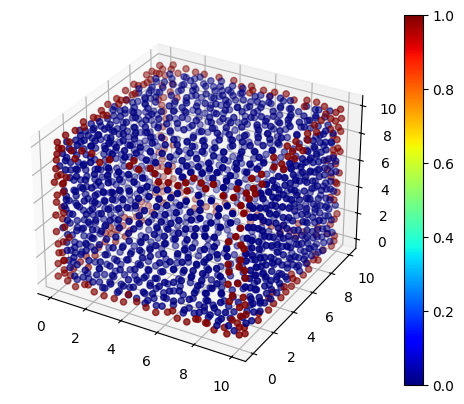

c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\io\ply.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = property_formats[str(df.dtypes[i])[0]]
c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\io\ply.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = property_formats[str(df.dtypes[i])[0]]
c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\io\ply.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

,x,y,z,e1(7),e2(7),e3(7)
0,1.059204,4.654830,10.000000,0.256662,0.114949,0.000000
1,10.000000,8.300475,1.556092,0.228309,0.136755,0.000000
2,5.248509,10.000000,5.131699,0.241354,0.131273,0.000000
3,10.000000,0.003074,5.737957,0.169535,0.083085,0.029499
4,5.888872,9.857782,0.000000,0.180467,0.117537,0.022582
...,...,...,...,...,...,...
1585,0.000000,6.519288,5.902257,0.280866,0.157919,0.000000
1586,6.317471,10.000000,4.121303,0.252780,0.140180,0.000000
1587,0.000000,4.628843,7.616939,0.208478,0.134531,0.000000
1588,0.252139,10.000000,1.734495,0.167264,0.108690,0.030086


In [93]:
Detect_edges()